In [15]:
import cv2
import numpy as np
from  matplotlib import pyplot as plt
%matplotlib inline

In [18]:
IMG_PATH_1 = r'D:\data\trainData\subject-level\Covid-19\P003\CT0032.png'
IMG_PATH_2 = r'D:\data\trainData\subject-level\Covid-19\P271\CT0143.png'

## 1 HE

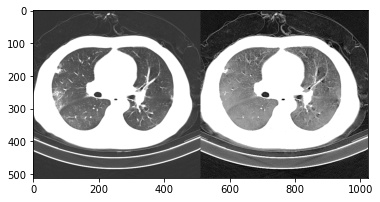

In [25]:
image = cv2.imread(IMG_PATH_1)
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image2 = cv2.equalizeHist(image1)
plt.imshow(np.hstack([image1, image2]), cmap=plt.cm.gray)
plt.show()

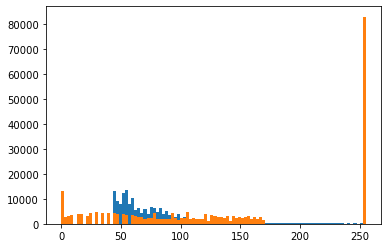

In [26]:
plt.hist(image1.flat, bins=100, range=(0, 255))
plt.hist(image2.flat, bins=100, range=(0, 255))
plt.show()

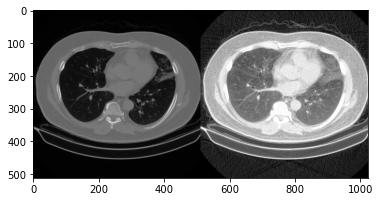

In [27]:
image = cv2.imread(IMG_PATH_2)
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image2 = cv2.equalizeHist(image1)
plt.imshow(np.hstack([image1, image2]), cmap=plt.cm.gray)
plt.show()

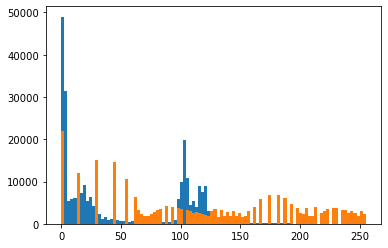

In [28]:
plt.hist(image1.flat, bins=100, range=(0, 255))
plt.hist(image2.flat, bins=100, range=(0, 255))
plt.show()

## 2 CLAHE

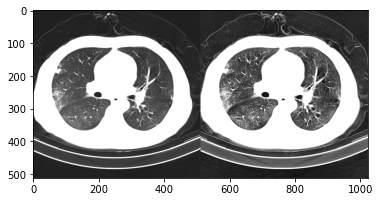

In [30]:
image = cv2.imread(IMG_PATH_1)
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
image2 = clahe.apply(image1)
plt.imshow(np.hstack([image1, image2]), cmap=plt.cm.gray)
plt.show()

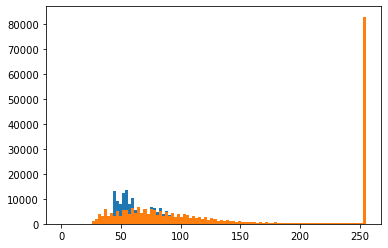

In [31]:
plt.hist(image1.flat, bins=100, range=(0, 255))
plt.hist(image2.flat, bins=100, range=(0, 255))
plt.show()

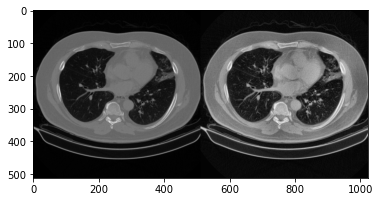

In [40]:
image = cv2.imread(IMG_PATH_2)
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
image2 = clahe.apply(image1)
plt.imshow(np.hstack([image1, image2]), cmap=plt.cm.gray)
plt.show()

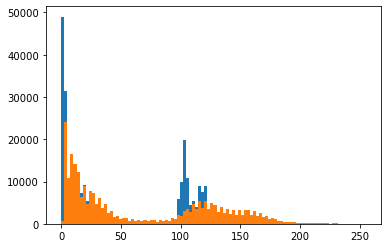

In [41]:
plt.hist(image1.flat, bins=100, range=(0, 255))
plt.hist(image2.flat, bins=100, range=(0, 255))
plt.show()

## 3 HE+CLAHE

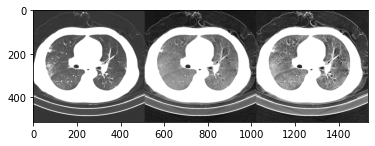

In [47]:
image = cv2.imread(IMG_PATH_1)
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image2 = cv2.equalizeHist(image1)
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
image3 = clahe.apply(image2)
plt.imshow(np.hstack([image1, image2, image3]), cmap=plt.cm.gray)
plt.show()

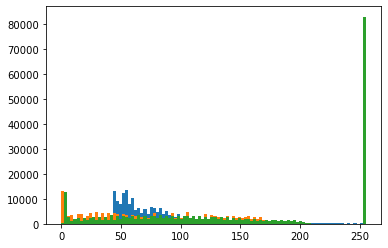

In [37]:
plt.hist(image1.flat, bins=100, range=(0, 255))
plt.hist(image2.flat, bins=100, range=(0, 255))
plt.hist(image3.flat, bins=100, range=(0, 255))
plt.show()

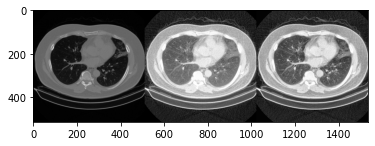

In [46]:
image = cv2.imread(IMG_PATH_2)
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image2 = cv2.equalizeHist(image1)
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
image3 = clahe.apply(image2)
plt.imshow(np.hstack([image1, image2, image3]), cmap=plt.cm.gray)
plt.show()

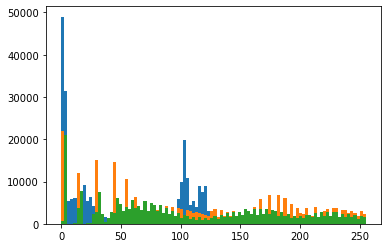

In [39]:
plt.hist(image1.flat, bins=100, range=(0, 255))
plt.hist(image2.flat, bins=100, range=(0, 255))
plt.hist(image3.flat, bins=100, range=(0, 255))
plt.show()

In [52]:
from PIL import Image
from scipy.optimize import minimize_scalar
import numpy as np
import cv2
import os

def linearStretching(x_c, x_max, x_min, l):
    return (l - 1) * (x_c - x_min) / (x_max - x_min)

def mapping(h, l):
    cum_sum = 0
    t = np.zeros_like(h, dtype=np.int)
    for i in range(l):
        cum_sum += h[i]
        t[i] = np.ceil((l - 1) * cum_sum + 0.5)
    
    return t
    
def f(lam, h_i, h_u, l):
    h_tilde = 1 / (1 + lam) * h_i + lam / (1 + lam) * h_u
    t = mapping(h_tilde, l)
    d = 0
    for i in range(l):
        for j in range(i + 1):
            if h_tilde[i] > 0 and h_tilde[j] > 0 and t[i] == t[j]:
                d = max(d, i - j)
    
    return d

def huePreservation(g_i, i, x_hat_c, l):
    g_i_f = g_i.flatten()
    i_f = i.flatten()
    x_hat_c_f = x_hat_c.flatten()
    g_c = np.zeros(g_i_f.shape)
    g_c[g_i_f <= i_f] = (g_i_f / i_f * x_hat_c_f)[g_i_f <= i_f]
    g_c[g_i_f > i_f] = ((l - 1 - g_i_f) / (l - 1 - i_f) * (x_hat_c_f - i_f) + g_i_f)[g_i_f > i_f]
    
    return g_c.reshape(i.shape)

def fusion(i):
    lap = cv2.Laplacian(i.astype(np.uint8), cv2.CV_16S, ksize=3)
    c_d = np.array(cv2.convertScaleAbs(lap))
    #print(np.max(np.max(c_d)), np.min(np.min(c_d)))
    c_d = c_d / np.max(np.max(c_d)) + 0.00001
    i_scaled = (i - np.min(np.min(i))) / (np.max(np.max(i)) - np.min(np.min(i)))
    b_d = np.apply_along_axis(lambda x: np.exp(- (x - 0.5) ** 2 / (2 * 0.2 ** 2)), 0, i_scaled.flatten()).reshape(i.shape)
    w_d = np.minimum(c_d, b_d)
    
    return w_d

def main(x):
    x = np.array(x).astype(np.float64)
    x_r, x_g, x_b = x[:, :, 0], x[:, :, 1], x[:, :, 2]
    x_max = np.max(np.max(np.max(x)))
    x_min = np.min(np.min(np.min(x)))
    
    l = 256
    x_hat_r = linearStretching(x_r, x_max, x_min, l)
    x_hat_g = linearStretching(x_g, x_max, x_min, l)
    x_hat_b = linearStretching(x_b, x_max, x_min, l)
    i = (0.299 * x_hat_r + 0.587 * x_hat_g + 0.114 * x_hat_b).astype(np.uint8)
    
    h_i = np.bincount(i.flatten())
    h_i = np.concatenate((h_i, np.zeros(l - h_i.shape[0]))) / (i.shape[0] * i.shape[1])
    h_u = np.ones_like(h_i) * 1 / l
    
    result = minimize_scalar(f, method = "brent", args = (h_i, h_u, l))
    h_tilde = 1 / (1 + result.x) * h_i + result.x / (1 + result.x) * h_u
    t = mapping(h_tilde, l)
    g_i = np.apply_along_axis(lambda x: t[x], 0, i.flatten()).reshape(i.shape)
    
    g_r = huePreservation(g_i, i, x_hat_r, l)
    g_g = huePreservation(g_i, i, x_hat_g, l)
    g_b = huePreservation(g_i, i, x_hat_b, l)
    #glo = np.dstack((g_r, g_g, g_b)).astype(np.int)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_i = clahe.apply(i)
    l_r = huePreservation(l_i, i, x_hat_r, l)
    l_g = huePreservation(l_i, i, x_hat_g, l)
    l_b = huePreservation(l_i, i, x_hat_b, l)
    #loc = np.dstack((l_r, l_g, l_b)).astype(np.int)
    
    w_g = fusion(g_i)
    w_l = fusion(l_i)
    w_hat_g = w_g / (w_g + w_l)
    w_hat_l = w_l / (w_g + w_l)
    y_r = w_hat_g * g_r + w_hat_l * l_r
    y_g = w_hat_g * g_g + w_hat_l * l_g
    y_b = w_hat_g * g_b + w_hat_l * l_b
    y = np.dstack((y_r, y_g, y_b)).astype(np.uint8)
    return y
    


## 4 ACE

<ipython-input-52-98b578505128>:35: RuntimeWarning: divide by zero encountered in true_divide
  g_c[g_i_f <= i_f] = (g_i_f / i_f * x_hat_c_f)[g_i_f <= i_f]
<ipython-input-52-98b578505128>:35: RuntimeWarning: invalid value encountered in multiply
  g_c[g_i_f <= i_f] = (g_i_f / i_f * x_hat_c_f)[g_i_f <= i_f]
<ipython-input-52-98b578505128>:36: RuntimeWarning: divide by zero encountered in true_divide
  g_c[g_i_f > i_f] = ((l - 1 - g_i_f) / (l - 1 - i_f) * (x_hat_c_f - i_f) + g_i_f)[g_i_f > i_f]
<ipython-input-52-98b578505128>:36: RuntimeWarning: invalid value encountered in multiply
  g_c[g_i_f > i_f] = ((l - 1 - g_i_f) / (l - 1 - i_f) * (x_hat_c_f - i_f) + g_i_f)[g_i_f > i_f]
<ipython-input-52-98b578505128>:36: RuntimeWarning: invalid value encountered in true_divide
  g_c[g_i_f > i_f] = ((l - 1 - g_i_f) / (l - 1 - i_f) * (x_hat_c_f - i_f) + g_i_f)[g_i_f > i_f]


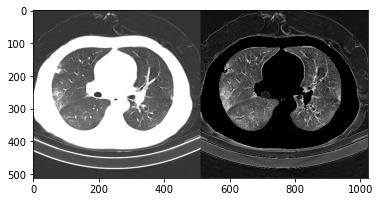

In [54]:
image = cv2.imread(IMG_PATH_1)
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(main(image), cv2.COLOR_BGR2GRAY)
plt.imshow(np.hstack([image1, image2]), cmap=plt.cm.gray)
plt.show()

<ipython-input-52-98b578505128>:35: RuntimeWarning: divide by zero encountered in true_divide
  g_c[g_i_f <= i_f] = (g_i_f / i_f * x_hat_c_f)[g_i_f <= i_f]
<ipython-input-52-98b578505128>:35: RuntimeWarning: invalid value encountered in multiply
  g_c[g_i_f <= i_f] = (g_i_f / i_f * x_hat_c_f)[g_i_f <= i_f]
<ipython-input-52-98b578505128>:36: RuntimeWarning: divide by zero encountered in true_divide
  g_c[g_i_f > i_f] = ((l - 1 - g_i_f) / (l - 1 - i_f) * (x_hat_c_f - i_f) + g_i_f)[g_i_f > i_f]
<ipython-input-52-98b578505128>:36: RuntimeWarning: invalid value encountered in multiply
  g_c[g_i_f > i_f] = ((l - 1 - g_i_f) / (l - 1 - i_f) * (x_hat_c_f - i_f) + g_i_f)[g_i_f > i_f]
<ipython-input-52-98b578505128>:36: RuntimeWarning: invalid value encountered in true_divide
  g_c[g_i_f > i_f] = ((l - 1 - g_i_f) / (l - 1 - i_f) * (x_hat_c_f - i_f) + g_i_f)[g_i_f > i_f]


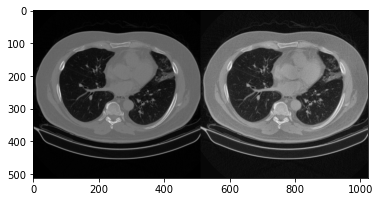

In [55]:
image = cv2.imread(IMG_PATH_2)
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(main(image), cv2.COLOR_BGR2GRAY)
plt.imshow(np.hstack([image1, image2]), cmap=plt.cm.gray)
plt.show()